- Resample to 256x256xZ
- HU value: -700 to 300
- Min-max scaling
- Crop? (Future work)
- Spilt in train-val
- Save as numpy

In [1]:
import nibabel as nib
import numpy as np
import os
from pathlib import Path
import torch
import nibabel.processing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
root_path = Path("/scratch/scratch6/akansh12/Parse_data/train/train/")
train_image_file = list(root_path.glob("*/image/*"))
train_label_file = list(root_path.glob("*/label/*"))

In [3]:
#helper
def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index("image")] = "label"  
    return Path(*parts)

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized 

def windowing(scan, window):
    min_value = window[0]
    max_value = window[1]
    return np.clip(scan,min_value, max_value)

def resample_ct(scan,shape, voxel_size, orientation):
    return nibabel.processing.conform(scan, shape, voxel_size, orientation = orientation)   

In [4]:
save_root = Path("/scratch/scratch6/akansh12/Parse_data/processed_train")
for counter, ct_file_path in enumerate(tqdm(train_image_file)):
    path_to_label = change_img_to_label_path(ct_file_path)
    ct_orig = nib.load(ct_file_path)
    ct_label = nib.load(path_to_label)
    
    #windowing
    ct_windowed = windowing(ct_orig.get_fdata(), [-700, 300])
    
    #Scaling
    standardized = standardize(ct_windowed)
       
    # Resample
    ct_orig = nib.Nifti1Image(standardized, ct_orig.affine)
    
    ct_orig_resampled = resample_ct(ct_orig, (256,256,ct_orig.shape[-1]), (2,2,2), 'LPS')
    ct_label_resample = resample_ct(ct_label, (256,256,ct_orig.shape[-1]), (2,2,2), 'LPS')    
    
    
    if counter < 90:
        current_path = save_root/"train"/ct_file_path.parts[-3]
    else:
        current_path = save_root/"val"/ct_file_path.parts[-3]
        
    ct_save_path = current_path/"image"
    ct_label_save_path = current_path/"label"
    
    ct_save_path.mkdir(parents=True, exist_ok=True)
    ct_label_save_path.mkdir(parents=True, exist_ok=True)

    nib.save(ct_orig_resampled, ct_save_path/ct_file_path.parts[-1])
    nib.save(ct_label_resample, ct_label_save_path/ct_file_path.parts[-1])

  0%|          | 0/100 [00:00<?, ?it/s]

In [106]:
a = np.load("/scratch/scratch6/akansh12/Parse_data/processed_train/train/PA000202/image/PA000202.npy")
b = np.load("/scratch/scratch6/akansh12/Parse_data/processed_train/train/PA000202/label/PA000202.npy")

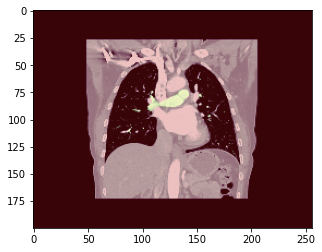

In [110]:
plt.imshow(np.rot90(a[:,128,:]), cmap= "bone")
plt.imshow(np.rot90(b[:,128,:]), alpha = 0.2, cmap= "autumn")

In [117]:
ct_file_path

PosixPath('/scratch/scratch6/akansh12/Parse_data/train/train/PA000202/image/PA000202.nii.gz')

In [62]:
a[:,128,:]

array([[0.7, 0.7, 0.7, ..., 0.7, 0.7, 0.7],
       [0.7, 0.7, 0.7, ..., 0.7, 0.7, 0.7],
       [0.7, 0.7, 0.7, ..., 0.7, 0.7, 0.7],
       ...,
       [0.7, 0.7, 0.7, ..., 0.7, 0.7, 0.7],
       [0.7, 0.7, 0.7, ..., 0.7, 0.7, 0.7],
       [0.7, 0.7, 0.7, ..., 0.7, 0.7, 0.7]])

In [73]:
ct_file_path = train_image_file[0]
ct_orig = nib.load(ct_file_path)
ct_orig_data = ct_orig.get_fdata()

In [74]:
a = windowing(ct_orig_data,[-700, 300])

In [75]:
a = standardize(a)

In [83]:
a = nib.Nifti1Image(a, ct_orig.affine)

In [84]:
b = resample_ct(a, (256,256,200), (2,2,2), 'LPS')

In [89]:
np.max(a.get_fdata()[:,128,:])

1.0

In [86]:
np.max(b.get_fdata()[:,128,:])

1.064108500775175

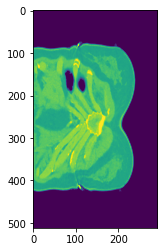

In [92]:
plt.imshow(a.get_fdata()[:,128,:])

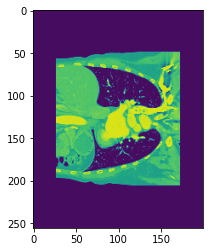

In [94]:
plt.imshow(b.get_fdata()[:,128,:])